<a href="https://colab.research.google.com/github/evansemet/Jane-Street-Solutions/blob/main/2023_02_Twenty_Four_Seven_(Four_in_One).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
from z3 import *
from scipy.ndimage import measurements
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.morphology import label
import matplotlib
from IPython.display import Markdown, display

In [ ]:
grid = np.array([[0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,1,0,0,0,0,0,6,5,0],
                 [0,0,0,0,0,3,0,0,0,0,6,0],
                 [0,4,0,0,0,0,0,0,7,0,0,0],
                 [0,0,0,0,2,0,0,0,0,0,0,7],
                 [0,0,6,0,0,0,0,0,3,7,0,0],
                 [0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,7,0,5,0,0,0,0,0,0],
                 [0,5,0,0,0,7,0,0,0,0,0,0],
                 [0,6,7,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,6,0,0,0,0,0,0,0]], dtype=int)

cols_top = np.array([6,36,30,34,27,3,40,27,0,0,7,0], dtype=int)
cols_bot = np.array([6,0,0,4,0,0,0,0,0,0,0,5], dtype=int)

rows_l = np.array([5,7,7,33,29,2,40,28,0,0,36,0], dtype=int)
rows_r = np.array([4,0,0,1,0,0,0,0,0,0,0,7], dtype=int)

In [ ]:
def neighbours(i, j):
  l=[]
  if i-1 >= 0: l.append((i-1,j))
  if i+1 < 12: l.append((i+1,j))
  if j-1 >= 0: l.append((i,j-1))
  if j+1 < 12: l.append((i,j+1))
  return l

def areas(grid):
  labels, num = measurements.label(grid < 1)
  areas = measurements.sum(grid < 1, labels, index=range(1, num + 1))
  return np.prod(areas)

3 solutions took 0.8405 seconds



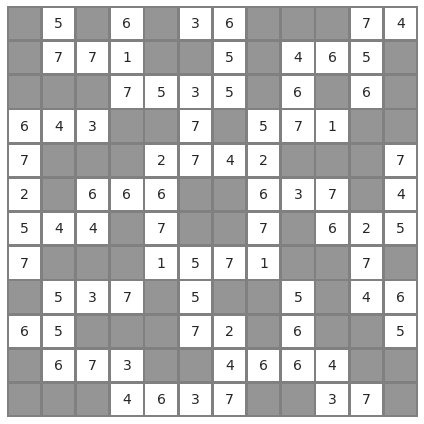

### Solution is 74,649,600

In [ ]:
start = time.time()
s = Solver()

whole = np.array(IntVector("x", 12**2), dtype=object).reshape((12,12))
top_l = np.array(IntVector("a", 7**2), dtype=object).reshape((7,7))
top_r = np.array(IntVector("b", 7**2), dtype=object).reshape((7,7))
bot_l = np.array(IntVector("c", 7**2), dtype=object).reshape((7,7))
bot_r = np.array(IntVector("d", 7**2), dtype=object).reshape((7,7))

# whole grid has to match the values of the 4 7x7s
s += [And(e==whole[i][j], top_r[i][j]==whole[i][j+5], bot_l[i][j]==whole[i+5][j], \
          bot_r[i][j]==whole[i+5][j+5]) for (i,j),e in np.ndenumerate(top_l)]

# # every number from 0 to 7 and matches input given
s += [And(e >= 0, e <= 7) for _, e in np.ndenumerate(whole)]
s += [whole[i][j] == int(grid[i][j]) for j in range(12) for i in range(12) if grid[i][j] > 0]
# at least one empty
s += [Or(whole[i][j] ==0,whole[i+1][j] ==0,whole[i][j+1] ==0,whole[i+1][j+1] ==0) for j in range(11) for i in range(11)]
# at least one neighbor
s += [Implies(whole[i][j] !=0,Or([whole[k][l] !=0 for (k,l) in neighbours(i,j)])) for j in range(12) for i in range(12)]

# rules for each 7x7
for x7 in [top_l, top_r, bot_l, bot_r]:
  # row and col totals
  s += [Sum([x7[i][j] for i in range(7)]) == 20 for j in range(7)]
  s += [Sum([x7[i][j] for j in range(7)]) == 20 for i in range(7)]
  # 4 numbers in each row and col
  s += [PbEq([(x7[i][j] ==0,1) for i in range(7)],3) for j in range(7)]
  s += [PbEq([(x7[i][j] ==0,1) for j in range(7)],3) for i in range(7)]
  # n instances of n
  s += [PbEq([(x7[i][j] == n,1) for j in range(7) for i in range(7)],n) for n in range(1,8)]

for n in range(12):
  if cols_top[n] > 0:
    s += Or(Sum([whole[i][n] for i in range(12)])==int(cols_top[n]), \
            If(whole[0][n] == 0,If(whole[1][n] == 0,If(whole[2][n] == 0,whole[3][n] == int(cols_top[n]), \
            whole[2][n] == int(cols_top[n])),whole[1][n] == int(cols_top[n])),whole[0][n] == int(cols_top[n])))

  if cols_bot[n] > 0:
    s += Or(Sum([whole[i][n] for i in range(12)])==int(cols_bot[n]), \
            If(whole[11][n] == 0,If(whole[10][n] == 0,If(whole[9][n] == 0,whole[8][n] == int(cols_bot[n]), \
            whole[9][n] == int(cols_bot[n])),whole[10][n] == int(cols_bot[n])),whole[11][n] == int(cols_bot[n])))

  if rows_l[n] > 0:
    s += Or(Sum([whole[n][i] for i in range(12)])==int(rows_l[n]), \
            If(whole[n][0] == 0,If(whole[n][1] == 0,If(whole[n][2] == 0,whole[n][3] == int(rows_l[n]), \
            whole[n][2] == int(rows_l[n])),whole[n][1] == int(rows_l[n])),whole[n][0] == int(rows_l[n])))

  if rows_r[n] > 0:
    s += Or(Sum([whole[n][i] for i in range(12)])==int(rows_r[n]), \
            If(whole[n][11] == 0,If(whole[n][10] == 0,If(whole[n][9] == 0,whole[n][8] == int(rows_r[n]), \
            whole[n][9] == int(rows_r[n])), whole[n][10] == int(rows_r[n])),whole[n][11] == int(rows_r[n])))

count = 0
while True:   
  if s.check() == sat:
    count += 1
    m = s.model()
    x = np.array([[m.evaluate(whole[i][j]).as_long() for j in range(12)] for i in range(12)])
    if np.max(label(x != 0,connectivity=1)) == 1:
      break
    s += Or([whole[i][j]!=int(x[i,j]) for j in range(12) for i in range(12)])
  else:
    print("failed to solve") 
    break

print('{} solutions took {:0.4f} seconds\n'.format(count,time.time()-start))
fig, ax = plt.subplots(1,1,figsize=(6,6))
y = np.array(x).astype('int').astype('str')
y[y=="0"] =""
ax = sns.heatmap(x==0, annot=y, cbar=False, cmap="Greys", fmt="", linewidths=2, center=1, linecolor="grey", annot_kws={"size":14})
ax.axis("off")
plt.tight_layout()
plt.show()
display(Markdown('### Solution is {:,.0f}'.format((areas(x)))))